In [1]:
import numpy as np
import random
import os,sys
import requests
import torchvision

import urllib
import gzip

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# seaborn
import seaborn as sns
sns.set()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# load dataset
from utils import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset('cifar-10')

Loaded data ... Get data stats:
X_train: (45000, 3072) 	y_train: (45000,)
X_val: (5000, 3072) 	y_val: (5000,)
X_test: (10000, 3072) 	y_train: (10000,)
X_dev: (500, 3072) 	y_dev: (500,)


In [3]:
# dir for storing training curves
assets_dir = './assets/'
# create assets dir if it does not exist
if not os.path.exists(assets_dir):
    os.makedirs(assets_dir)

In [4]:
# num_samples_per_class = 5
# num_class = 10
# fig,axs = plt.subplots(nrows=num_samples_per_class,ncols=num_class,figsize=(20,10))

# for class_idx in range(num_class):
#     X_class = X_train[y_train==class_idx].reshape(-1,28,28)
#     choose = np.random.choice(range(len(X_class)),num_samples_per_class,replace=False)
#     X_sample = X_class[choose]
#     for sample_idx in range(num_samples_per_class):
#         axs[sample_idx,class_idx].imshow(X_sample[sample_idx],cmap='gray')
#         axs[sample_idx,class_idx].axis('off')
#         if sample_idx==0:
#             axs[sample_idx,class_idx].set_title("Class: {}".format(class_idx))

# plt.savefig(assets_dir+"class_sample_visualisation.png",dpi=300)
# plt.show()

In [5]:
# # compute mean for the training data
# X_mean = np.mean(X_train,axis=0)
# X_std = np.std(X_train,axis=0)

# subtract mean from the data
# X_train -= X_mean
# X_val -= X_mean
# X_test -= X_mean
# X_dev -= X_mean

# # scale the data from -1 to 1
X_train = (X_train - 0.5)/0.5 
X_val = (X_val - 0.5)/0.5 
X_test = (X_test - 0.5)/0.5 
# X_dev = (X_dev - 0.5)/0.5 

# X_train = (X_train - X_mean)/X_std 
# X_val = (X_val - X_mean)/X_std
# X_test = (X_test - X_mean)/X_std 
# X_dev = (X_dev - X_mean)/X_std

# # visualize data mean
# plt.imshow(X_mean.reshape(28,28),cmap='gray')
# plt.title('Visualizing mean of the training data')
# plt.axis('off')
# plt.show()

In [6]:
# verify data soundnes
np.mean(X_train), np.std(X_train),np.max(X_train),np.min(X_train) 

(-0.05311133238017409, 0.5033705120334038, 1.0, -1.0)

In [7]:
class Dataloader:
    def __init__(self,X,y,batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def __iter__(self):
        num_iter_per_epoch = len(self)
        idxs = np.arange(len(self.y))
        np.random.shuffle(idxs)
        for i in range(num_iter_per_epoch):
            batch_mask = idxs[i*self.batch_size:(i+1)*self.batch_size]
            data, labels = self.X[batch_mask],self.y[batch_mask]
            yield data,labels
            
    def __len__(self):
        return len(self.X)//self.batch_size

## Method

In [8]:
# xavier initialization of weights
def xavier(m,h):
    return np.sqrt(6./(m+h))*np.random.uniform(-1,1,size=(m,h))

# kaiming initialization of weights
def kaiming(m,h):
    return np.sqrt(2./m)*np.random.randn(m,h)

def xavier_v2(m,h):
    return np.sqrt(1./m)*np.random.uniform(-1,1,size=(m,h))

In [9]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
   
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)

    return dx, dw, db


def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_forward(x):
    out = sigmoid(x)
    cache = out
    return out,cache

def sigmoid_backward(dout,cache):
    h = cache
    return dout * h * (1-h)


def tanh_forward(x):
    out = (np.exp(2*x)-1)/(np.exp(2*x)+1)
    cache = out
    return out,cache

def tanh_backward(dout,cache):
    h = cache
    return dout * (1+h) * (1-h)

In [10]:
class Model:
    def __init__(self,input_size=28*28,num_hidden=400,num_classes=10,classification=False):
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.classification = classification
        self.num_out = num_classes
        self.reset()
        
    def reset(self):
        # initialize weights using Xavier init
        self.initialize_weights()
        # velocity for the momentum update rule
        self.v_w1,self.v_w2,self.v_b1,self.v_b2 = 0,0,0,0
    
    def initialize_weights(self):
        # Xavier initialization
        if self.classification:
            out_size = self.num_out
        else:
            out_size = self.input_size
            
        self.W1 = xavier_v2(self.input_size,self.num_hidden)
        self.W2 = xavier_v2(self.num_hidden,out_size)
        self.b1 = np.sqrt(1./self.input_size)*np.random.uniform(-1,1,size=(self.num_hidden))
        self.b2 = np.sqrt(1./self.num_hidden)*np.random.uniform(-1,1,size=(out_size))
    
    
    def softmax_loss(self,X,y,reg=0):
        # forward propagation 
        # (X --> h (-> h_) --> o (-> o_))
        h = X@self.W1 + self.b1
        h_ = sigmoid(h)
        out = h_@self.W2 + self.b2
        softmax_out = np.exp(out)/np.sum(np.exp(out),axis=1).reshape(-1,1)
        
        # compute loss
        loss = -np.log(softmax_out[range(out.shape[0]),y]).mean() + 0.5*reg*(np.sum(self.W1**2)
                                                                            +np.sum(self.W2**2))
        
        # back propagation
        dout = softmax_out
        dout[range(out.shape[0]),y] -= 1
        
        dW2 = h_.T @ dout/X.shape[0] + reg*self.W2
        db2 = np.mean(dout,axis=0)
        
        dh_ = dout @ self.W2.T
        dh = h_*(1-h_)*dh_
        
        dW1 = X.T @ dh/X.shape[0] + reg*self.W1
        db1 = np.mean(dh,axis=0)
        return loss,dW1,db1,dW2,db2
    
    
    def mse_loss(self,X,y,reg=0):
        # forward propagation 
        # (X --> h (-> h_) --> o (-> o_))
        
        h, cache_h = affine_forward(X,self.W1,self.b1)
        h_, cache_h_ = sigmoid_forward(h)
        
        o, cache_o = affine_forward(h_, self.W2, self.b2)
        o_, cache_o_ = tanh_forward(o)
        
        # compute loss
        loss = np.mean(np.sum((X-o_)**2,axis=-1))
        
        # backward pass
        dout = 2*(o_-X)/X.shape[0]
        dout = tanh_backward(dout,cache_o_)
        dout, dW2, db2 = affine_backward(dout,cache_o)
        
        dout = sigmoid_backward(dout,cache_h_)
        dout, dW1, db1 = affine_backward(dout,cache_h)
        
        return loss,dW1,db1,dW2,db2
    
    # stochastic gradient descent
    def sgd(self,grads,lr,momentum):
        dW1,db1,dW2,db2 = grads
        # Momentum update
        # update velocity
        self.v_w1 = momentum * self.v_w1 - lr * dW1
        self.v_w2 = momentum * self.v_w2 - lr * dW2 
        self.v_b1 = momentum * self.v_b1 - lr * db1 
        self.v_b2 = momentum * self.v_b2 - lr * db2 

        # update position
        self.W1 += self.v_w1
        self.W2 += self.v_w2
        self.b1 += self.v_b1
        self.b2 += self.v_b2
    
    def train(self,X_train,y_train,X_val,y_val,num_epochs=1,batch_size=64,lr=1e-3,reg=0,classification=False,
                    momentum=0,decay=0.1,decay_points=[20,50,80],log_interval=200,verbose=True):
        results = []
        for epoch in range(num_epochs):
            train_dataloader = Dataloader(X_train,y_train,batch_size)
            for batch_idx,(data,labels) in enumerate(train_dataloader):
                if not self.classification:
                    loss,dW1,db1,dW2,db2 = self.mse_loss(data,labels,reg)
                else:
                    loss,dW1,db1,dW2,db2 = self.softmax_loss(data,labels,reg)
                    
                # SGD on model paramters
                self.sgd((dW1,db1,dW2,db2),lr,momentum)
                
                if batch_idx%log_interval==0 and verbose:
                    print ("Epoch: [{}/{}] \tBatch: [{}/{}] \tloss: {:.4f}".format(epoch+1,num_epochs,
                                                                batch_idx,len(train_dataloader),loss))
            # decay learning rate
            if epoch in decay_points:
                lr *= decay
                print ("\nreducing learning rate to {:.4f} ...".format(lr))
            
            # compute train, val accuracy if performing classification
            if self.classification:
                val_loss,val_acc = self.test(X_val,y_val,batch_size=100,reg=reg)
                train_loss,train_acc = self.test(X_train,y_train,batch_size=100,reg=reg)
                results.append([train_loss,val_loss,train_acc,val_acc])
                if verbose:
                    print("\ntrain_loss: {:.4f}\t val_loss: {:.4f}\t train_acc: {:.4f}\t val_acc: {:.4f}\n"
                                                        .format(train_loss,val_loss,train_acc,val_acc))
        return np.array(results)
    
    def test(self,X,y,batch_size,reg=0):
        loss,num_correct = 0,0
        test_dataloader = Dataloader(X,y,batch_size)
        for batch_idx,(data,labels) in enumerate(test_dataloader):
            loss += self.softmax_loss(data,labels,reg)[0]*batch_size
            pred = self.predict(data)
            num_correct += np.sum(pred==labels)
        acc = num_correct/(batch_size*len(test_dataloader))
        loss /= (batch_size*len(test_dataloader))
        return loss,acc
                
    def predict(self,X):
        # return reconstructed data
        if self.classification:
            h = X@self.W1 + self.b1
            h_ = sigmoid(h)
            out = h_@self.W2 + self.b2
            pred = np.argmax(out,axis=1)
            return pred
        # return classification predictions
        else:
            h, cache_h = affine_forward(X,self.W1,self.b1)
            h_, cache_h_ = sigmoid_forward(h)

            o, cache_o = affine_forward(h_, self.W2, self.b2)
            o_, cache_o_ = tanh_forward(o)
            return o_
    
    def get_hidden_features(self,X):
        if self.classification:
            h = X@self.W1 + self.b1
            h_ = sigmoid(h)
            return h_
        else:
            h, cache_h = affine_forward(X,self.W1,self.b1)
            h_, cache_h_ = sigmoid_forward(h)
            return h_

In [11]:
# train using full training data
model = Model(input_size=X_train.shape[-1],num_hidden=128,num_classes=10,classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2)

# save results for comparison with best model
base_model_results = results

Epoch: [1/10] 	Batch: [0/703] 	loss: 1104.7784
Epoch: [1/10] 	Batch: [400/703] 	loss: 241.2902


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jsingh/anaconda3/envs/cv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-de22299e2477>", line 5, in <module>
    momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2)
  File "<ipython-input-10-2a2e9355b5d9>", line 101, in train
    loss,dW1,db1,dW2,db2 = self.mse_loss(data,labels,reg)
  File "<ipython-input-10-2a2e9355b5d9>", line 74, in mse_loss
    dout, dW1, db1 = affine_backward(dout,cache_h)
  File "<ipython-input-9-dab75b947344>", line 37, in affine_backward
    dx = dout.dot(w.T).reshape(x.shape)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jsingh/anaconda3/envs/cv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'Keyboard

KeyboardInterrupt: 

## Testing Model

In [37]:
def visualize(X,title=''):
    mean, std = 0.5, 0.5
    X = std*X + mean
    if X.shape[-1]==784:
        X = X.reshape(-1,28,28)
    else:
        X = np.reshape(X,(-1,3,32,32)).transpose(0,2,3,1)
    X = X[:16]
    
    fig,axs = plt.subplots(nrows=4,ncols=4,figsize=(5,6))
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            ax.imshow(X[4*i+j],cmap='gray')
            ax.axis(False)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [38]:
test_loader = Dataloader(X_train,y_train,16)

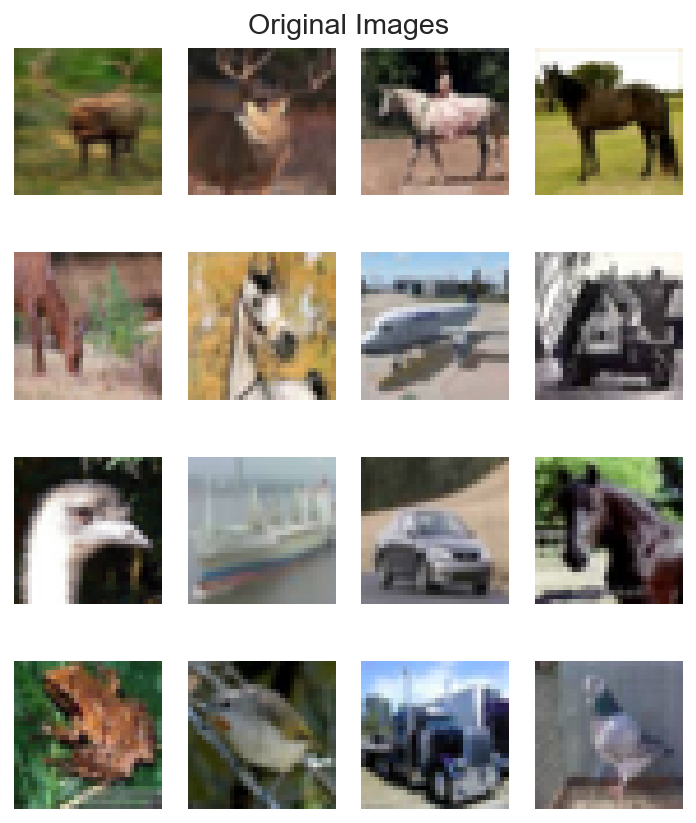

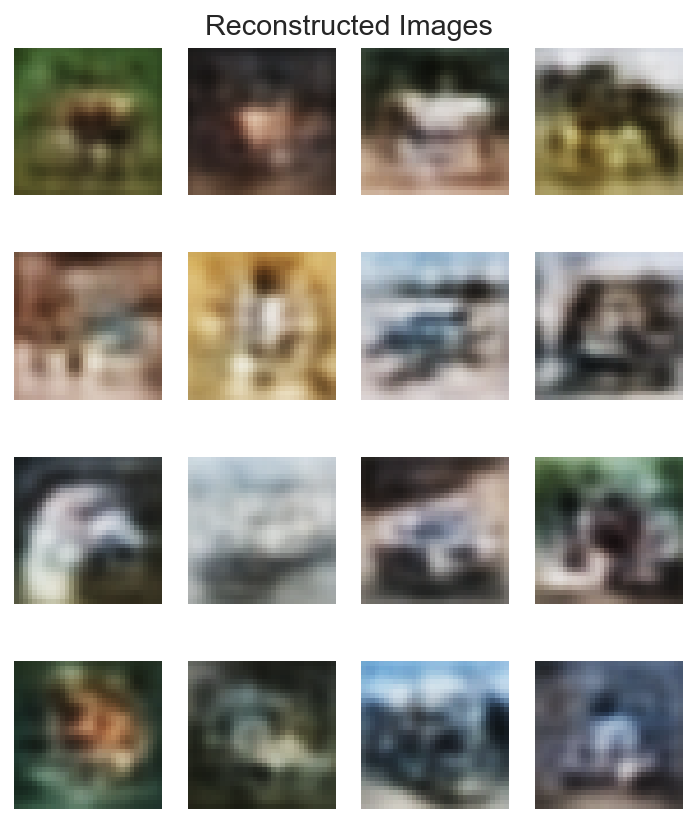

In [39]:
data = next(iter(test_loader))[0]

# visualize original data
visualize(data,'Original Images')

# visualize reconstructed output
visualize(model.predict(data),'Reconstructed Images')

## Evaluation 1: Reconstruction Error

In [24]:
# plot reconstruction error vs hidden size
num_epochs=10
error_log = []
hidden_size_list = [4,8,16,64,128,256]

for hidden_size in hidden_size_list:
    model = Model(num_hidden=hidden_size)
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    # compute reconstruction loss on test data
    X_test_pred = model.predict(X_test)
    error_log.append(np.mean(np.sum((X_test-X_test_pred)**2,axis=-1)))    

KeyboardInterrupt: 

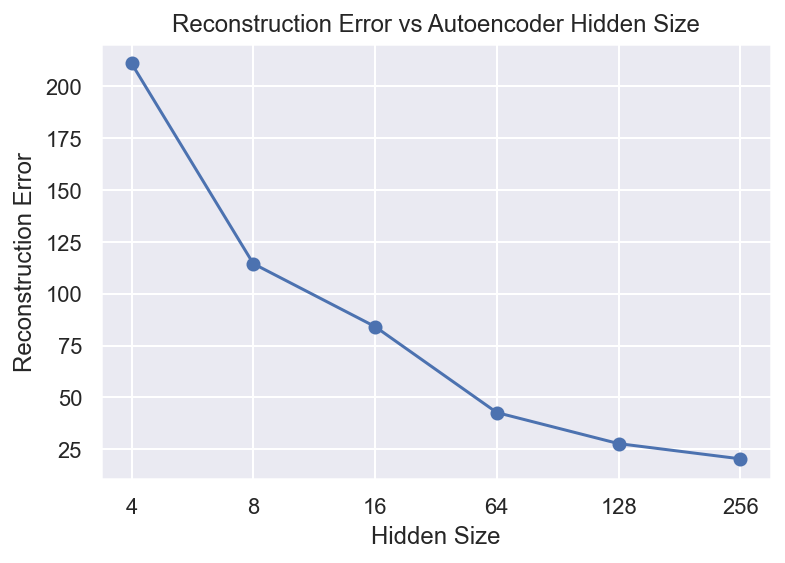

In [50]:
plt.plot(error_log,'-o')
plt.xticks(range(len(error_log)),hidden_size_list)
plt.xlabel('Hidden Size')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Autoencoder Hidden Size')
plt.show()

## Evaluation 1 and 2:  Reconstruction Error and Classification Error

In [12]:
def get_reconstruction_error(X_in, X_pred):
    """
    Get reconstruction error given original data and reconstructed output
    """
    error = np.mean(np.sum((X_in-X_pred)**2,axis=-1))
    return error


def get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test):
    # train a classification model on reduced data
    cls_model = Model(input_size=model.num_hidden,num_hidden=128,num_classes=10,classification=True)
    prefix = 'eval_cls_model'
    results = cls_model.train(X_reduced_train,y_train,X_reduced_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)

    # test on test datase
    test_loss,test_acc = cls_model.test(X_reduced_test,y_test,batch_size=100)
    return test_acc


def get_compression_efficiency():
    pass

In [13]:
# plot classification acc on reduced dimension data vs hidden size
num_epochs=10
error_log = []
cls_acc_log = []
hidden_size_list = [4,8,16,64,128,256]

for hidden_size in hidden_size_list:
    model = Model(num_hidden=hidden_size,input_size=X_train.shape[-1])
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    # compute reconstruction loss on test data
    X_test_pred = model.predict(X_test)
    error_log.append(np.mean(np.sum((X_test-X_test_pred)**2,axis=-1)))
    
    # extract reduced dimension data
    X_reduced_train = model.get_hidden_features(X_train)
    X_reduced_val = model.get_hidden_features(X_val)
    X_reduced_test = model.get_hidden_features(X_test)
    
    # train a classification model on reduced data
    cls_model = Model(input_size=model.num_hidden,num_hidden=128,num_classes=10,classification=True)
    prefix = 'eval_cls_model'
    results = cls_model.train(X_reduced_train,y_train,X_reduced_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)

    # test on test datase
    test_loss,test_acc = cls_model.test(X_reduced_test,y_test,batch_size=100)
    cls_acc_log.append(test_acc)

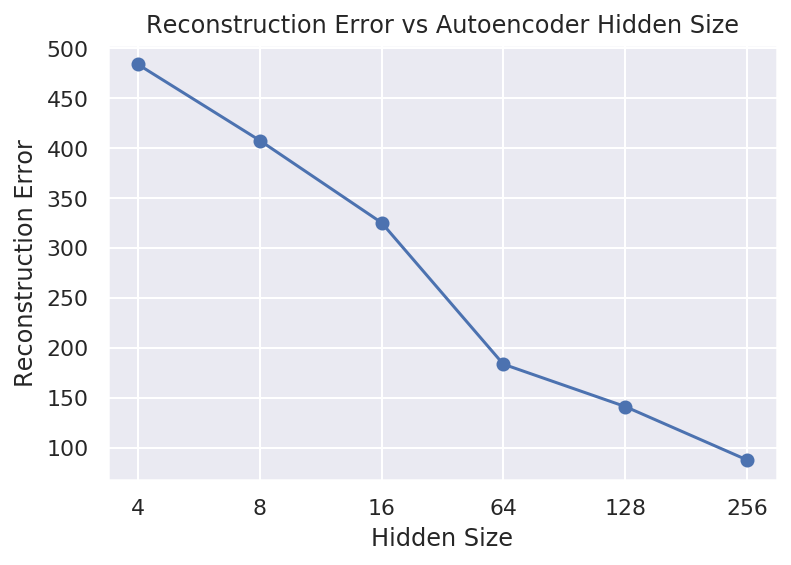

In [14]:
plt.plot(error_log,'-o')
plt.xticks(range(len(error_log)),hidden_size_list)
plt.xlabel('Hidden Size')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Autoencoder Hidden Size')
plt.show()

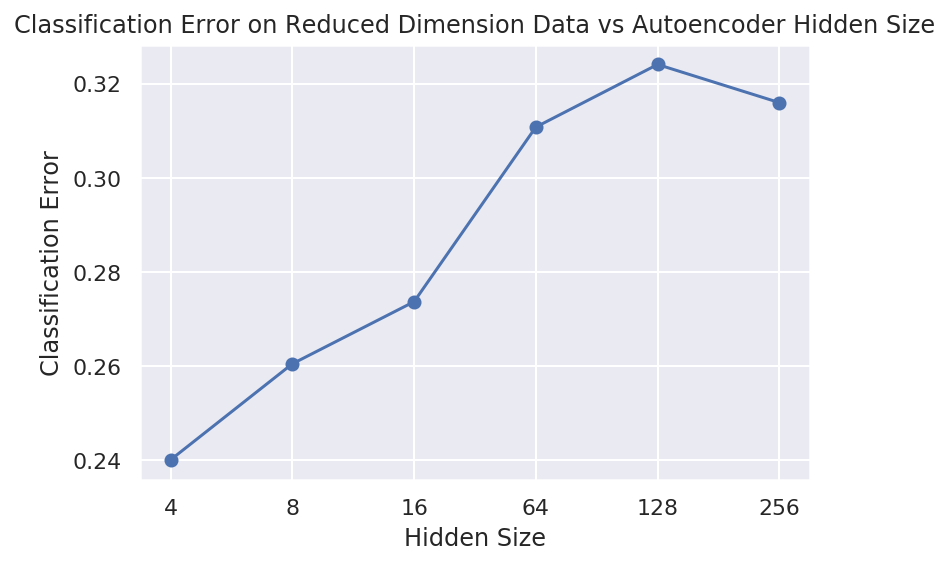

In [15]:
plt.plot(cls_acc_log,'-o')
plt.xticks(range(len(cls_acc_log )),hidden_size_list)
plt.xlabel('Hidden Size')
plt.ylabel('Classification Error')
plt.title('Classification Error on Reduced Dimension Data vs Autoencoder Hidden Size')
plt.show()

## Evaluation 3: Compression Efficiency

In [19]:
thresh_acc = 0.4
hidden_up = 256
hidden_low = 128
acc_up = 1
acc_low = 0

num_epochs=10
hidden_size = hidden_size_prev = 4
hidden_thresh = 4

while hidden_up - hidden_low > hidden_thresh:
    hidden_size = int((hidden_up + hidden_low)/2)
    model = Model(input_size=X_train.shape[-1],num_hidden=hidden_size,num_classes=10,classification=False)
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    
    # extract reduced dimension data
    X_reduced_train = model.get_hidden_features(X_train)
    X_reduced_val = model.get_hidden_features(X_val)
    X_reduced_test = model.get_hidden_features(X_test)
    
    test_acc = get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test)
    print ("Search stats: ", hidden_up,hidden_low,hidden_size,test_acc)
    
    if test_acc < thresh_acc:
        hidden_low = int((hidden_up + hidden_low)/2)
    else:
        hidden_up = int((hidden_up + hidden_low)/2)
        
# get final accuracy   
hidden_size = int((hidden_up + hidden_low)/2)
model = Model(input_size=28*28,num_hidden=hidden_size,num_classes=10,classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)

# extract reduced dimension data
X_reduced_train = model.get_hidden_features(X_train)
X_reduced_val = model.get_hidden_features(X_val)
X_reduced_test = model.get_hidden_features(X_test)

test_acc = get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test)
print ("Final hidden size: {}\t Test accuracy: {:.2f}%\t Threshold accuracy: {:.2f}%".format(hidden_size,100*test_acc,100*thresh_acc))
input_size = X_test.shape[1]
print ("Compression efficiency: {:.2f}%".format(100 - 100*hidden_size/input_size))

Search stats:  128 4 66 0.3078


KeyboardInterrupt: 

## Convenience Function

In [15]:
def get_reduced_dimension_data(X_in,reduced_dimension=32, X_train=None):
    # normalize data before feeding to neural network (assuming X is not normalized before)
    X_train = (X_train-0.5)/0.5
    X_in = (X_in-0.5)/0.5
    
    # train using full training data
    model = Model(input_size=X_train.shape[1],num_hidden=reduced_dimension, classification=False)
    prefix = 'base_model'
    print ("training autoencoder")
    results = model.train(X_train,y_train=np.ones(X_train.shape[0],dtype=np.uint8),X_val=None,y_val=None,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    
    print ("getting reduced dimension data")
    # get reduced dimension data
    X_reduced = model.get_hidden_features(X_in)
    return X_reduced

# Visualizations

In [20]:
from visualize import visualize_2d, visualize_3d
%matplotlib notebook

In [48]:
def normalize(X_train,X_val,X_test):
    # # scale the data from -1 to 1
    X_train = (X_train - 0.5) / 0.5
    X_val = (X_val - 0.5) / 0.5
    X_test = (X_test - 0.5) / 0.5
    return X_train, X_val, X_test


def pca(train_data,test_data,k):
    
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    
    train_data_mean = np.mean(train_data , axis = 0) 
    train_c = train_data - train_data_mean
    #print(train_c.shape)
    
    #covariance matrix, rowvar = False because columns are variables and rows observations 
    S = np.cov(train_c, rowvar = False)
    #print(S.shape)
   
    #find eigenval, eigenvec    
    eigval, eigvec = np.linalg.eigh(S) 
    
    o_eigval = np.flip(eigval)
    o_eigvec = np.flip(eigvec, axis=1)
    #print(o_eigval.shape)
    #print(o_eigvec.shape)
    
    #principal components
    pcs = o_eigvec[:,:k]
    #print(pcs.shape)
    # centering test data
    test_c = test_data - train_data_mean
    
    #dimesionality reduced new data
    red_data_t = np.dot(pcs.T, test_c.T)
    #print(red_data_t.shape)
    
    #reconstruct data
    recon_data_c = np.dot(pcs, red_data_t)
    recon_data = recon_data_c.T + train_data_mean
    #recon_data = recon_data_t.T
    red_data = red_data_t.T
    #print(recon_data.shape)
    
    return recon_data,red_data
    

### MNIST

In [24]:
#### READ DATA -
# load dataset
dataset = 'fashion-mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset('fashion-mnist')
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)


In [26]:
#reduced data -
model = Model(num_hidden=2,input_size=X_train.shape[-1])
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)
X_test_reduced = model.get_hidden_features(X_test)

Epoch: [1/10] 	Batch: [0/859] 	loss: 645.4001
Epoch: [1/10] 	Batch: [400/859] 	loss: 274.8409
Epoch: [1/10] 	Batch: [800/859] 	loss: 283.1646
Epoch: [2/10] 	Batch: [0/859] 	loss: 264.1361
Epoch: [2/10] 	Batch: [400/859] 	loss: 275.4218
Epoch: [2/10] 	Batch: [800/859] 	loss: 270.7061
Epoch: [3/10] 	Batch: [0/859] 	loss: 278.6821
Epoch: [3/10] 	Batch: [400/859] 	loss: 278.9461
Epoch: [3/10] 	Batch: [800/859] 	loss: 286.3711
Epoch: [4/10] 	Batch: [0/859] 	loss: 272.1894
Epoch: [4/10] 	Batch: [400/859] 	loss: 267.8529
Epoch: [4/10] 	Batch: [800/859] 	loss: 272.5592
Epoch: [5/10] 	Batch: [0/859] 	loss: 259.0931
Epoch: [5/10] 	Batch: [400/859] 	loss: 257.3253
Epoch: [5/10] 	Batch: [800/859] 	loss: 251.6645
Epoch: [6/10] 	Batch: [0/859] 	loss: 272.9254
Epoch: [6/10] 	Batch: [400/859] 	loss: 262.0215
Epoch: [6/10] 	Batch: [800/859] 	loss: 280.3866
Epoch: [7/10] 	Batch: [0/859] 	loss: 266.9136
Epoch: [7/10] 	Batch: [400/859] 	loss: 259.1182
Epoch: [7/10] 	Batch: [800/859] 	loss: 288.8260
Epoch:

In [29]:
X_test_reduced.shape

(10000, 2)

In [35]:
np.max(X_test_reduced[:,1])

0.8860789519451702

<IPython.core.display.Javascript object>


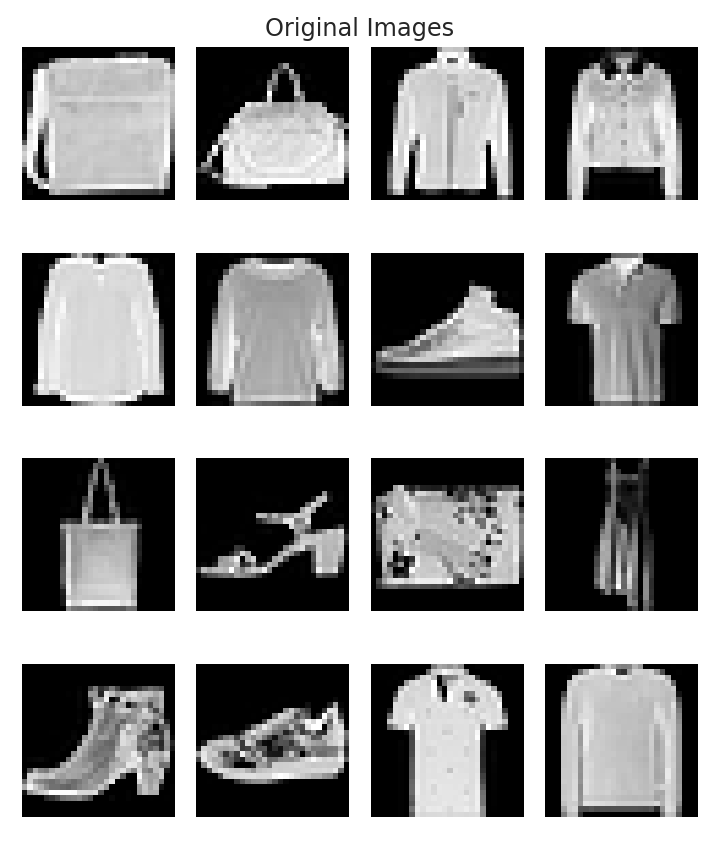

<IPython.core.display.Javascript object>


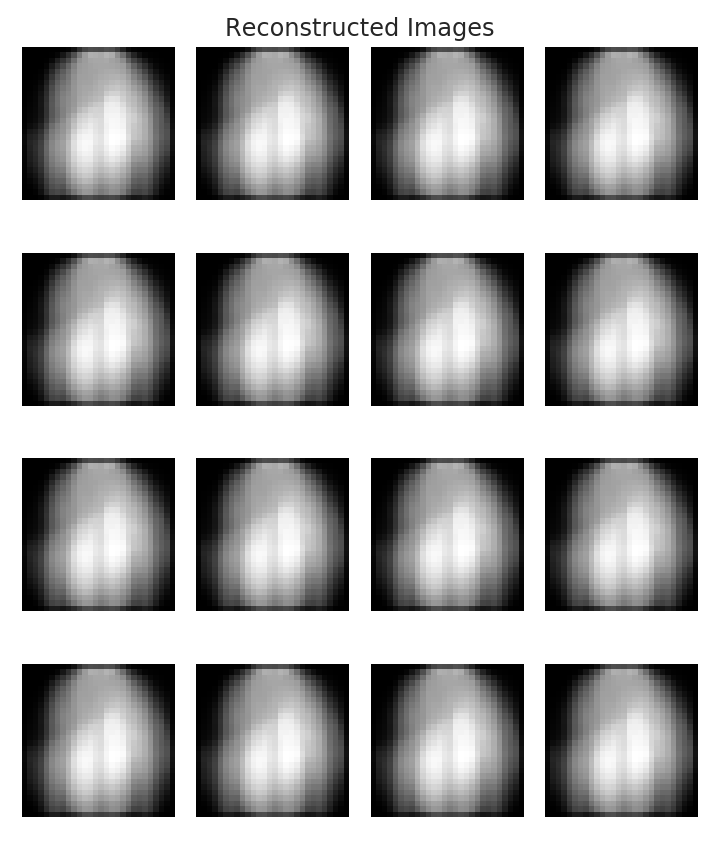

In [38]:
def visualize(X,title=''):
    mean, std = 0.5, 0.5
    X = std*X + mean
    if X.shape[-1]==784:
        X = X.reshape(-1,28,28)
    else:
        X = np.reshape(X,(-1,3,32,32)).transpose(0,2,3,1)
    X = X[:16]
    
    fig,axs = plt.subplots(nrows=4,ncols=4,figsize=(5,6))
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            ax.imshow(X[4*i+j],cmap='gray')
            ax.axis(False)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
test_loader = Dataloader(X_train,y_train,16)

data = next(iter(test_loader))[0]

# visualize original data
visualize(data,'Original Images')

# visualize reconstructed output
visualize(model.predict(data),'Reconstructed Images')

In [60]:
#reduced data -
dataset = 'mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=128,input_size=X_train.shape[-1])
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)
Epoch: [1/10] 	Batch: [0/859] 	loss: 764.5139
Epoch: [1/10] 	Batch: [400/859] 	loss: 79.3894
Epoch: [1/10] 	Batch: [800/859] 	loss: 59.9214
Epoch: [2/10] 	Batch: [0/859] 	loss: 58.6330
Epoch: [2/10] 	Batch: [400/859] 	loss: 42.5693
Epoch: [2/10] 	Batch: [800/859] 	loss: 36.3121
Epoch: [3/10] 	Batch: [0/859] 	loss: 43.0192
Epoch: [3/10] 	Batch: [400/859] 	loss: 35.1741
Epoch: [3/10] 	Batch: [800/859] 	loss: 33.6371
Epoch: [4/10] 	Batch: [0/859] 	loss: 32.1634
Epoch: [4/10] 	Batch: [400/859] 	loss: 30.1264
Epoch: [4/10] 	Batch: [800/859] 	loss: 26.6082
Epoch: [5/10] 	Batch: [0/859] 	loss: 28.0362
Epoch: [5/10] 	Batch: [400/859] 	loss: 28.2052
Epoch: [5/10] 	Batch: [800/859] 	loss: 27.0573
Epoch: [6/10] 	Batch: [0/859] 	loss: 25.9913
Epoch: [6/10] 	Batch: [400/859] 	loss: 27.9021
Epoch: [6/10] 	Batch: [800/859]

<IPython.core.display.Javascript object>


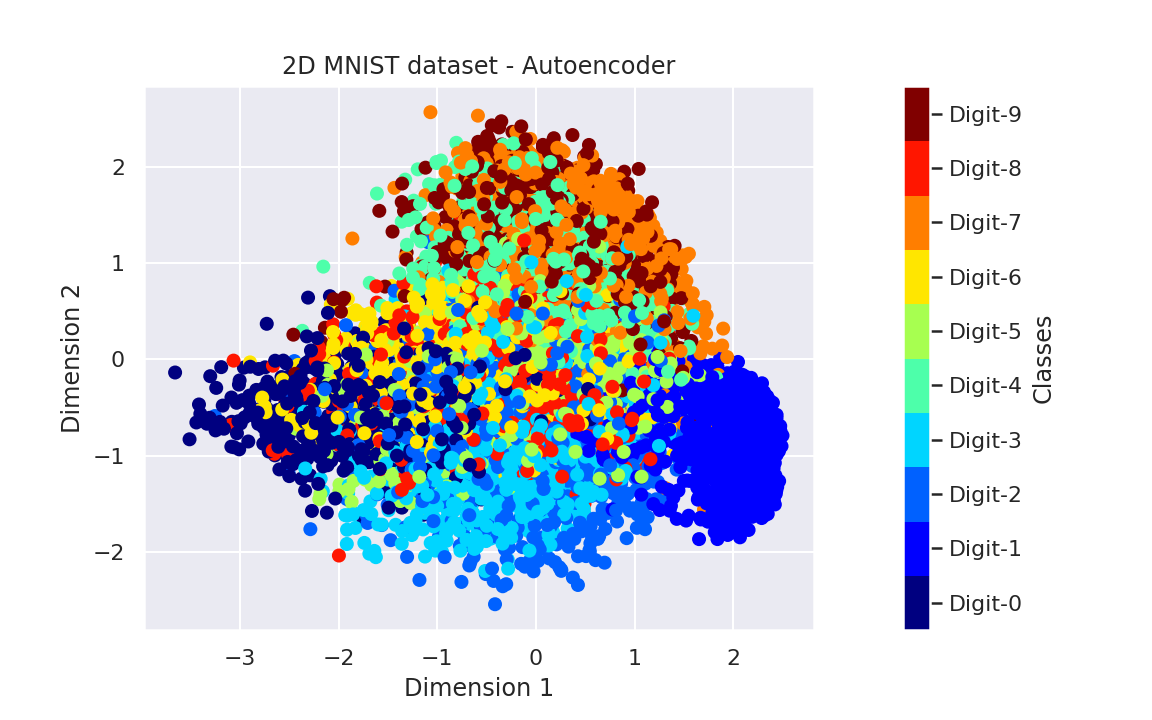

In [61]:
visualize_2d(X_test_reduced, y_test, "2D MNIST dataset - Autoencoder", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                 "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                 "Digit-8","Digit-9"], "2d_plots/auto_mnist.png", 
                                                                         "Dimension 1", "Dimension 2")

In [64]:
#reduced data -
dataset = 'mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

# model = Model(num_hidden=128,input_size=X_train.shape[-1])
# prefix = 'base_model'
# results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
#                       momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)


<IPython.core.display.Javascript object>


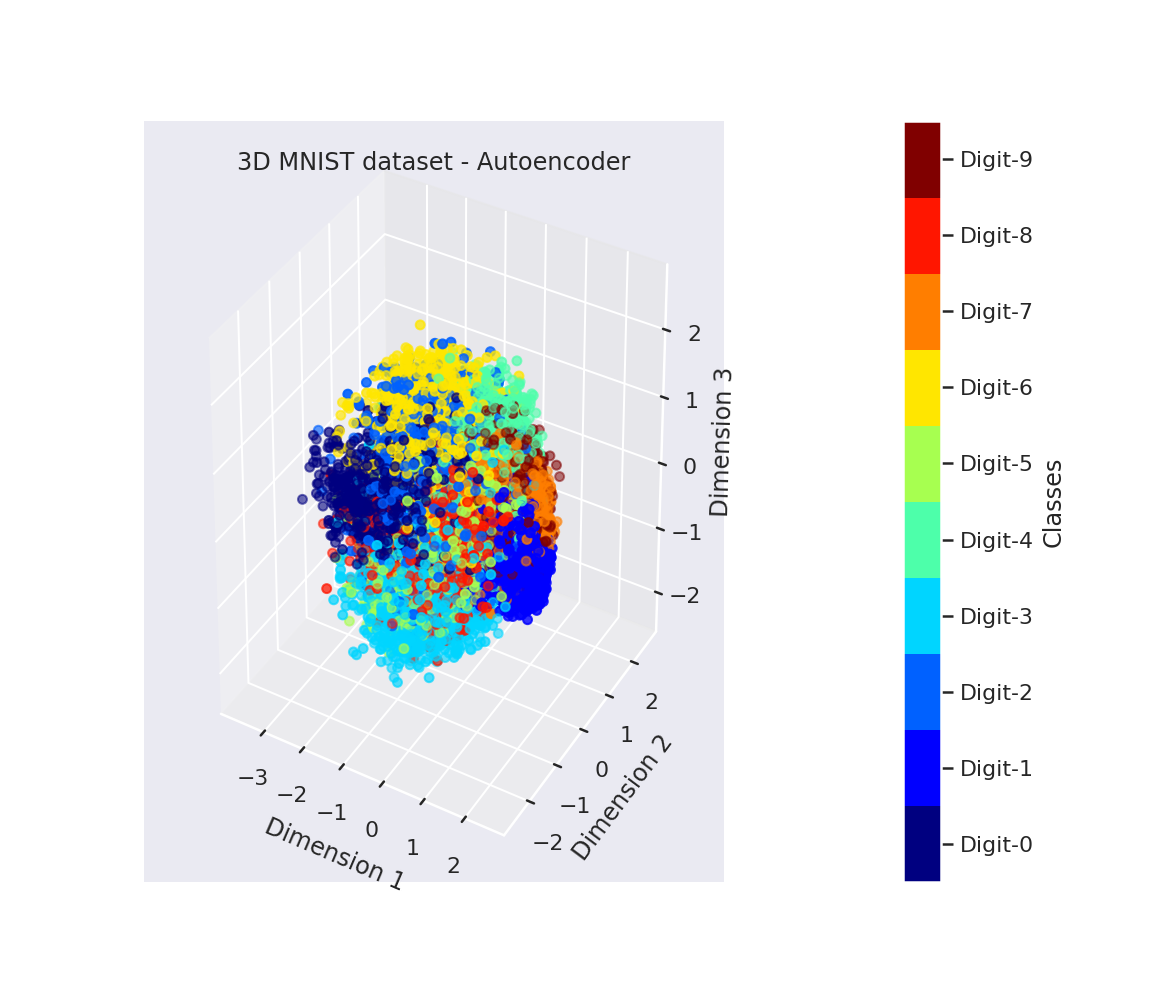

In [65]:
visualize_3d(X_test_reduced,y_test, "3D MNIST dataset - Autoencoder", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                             "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                             "Digit-8","Digit-9"], "Dimension 1", 
                                                                         "Dimension 2", "Dimension 3")

#### Classification mode

In [56]:
#reduced data -
dataset = 'mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=128,input_size=X_train.shape[-1],classification=True)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)
Epoch: [1/10] 	Batch: [0/859] 	loss: 2.3453
Epoch: [1/10] 	Batch: [400/859] 	loss: 1.8788
Epoch: [1/10] 	Batch: [800/859] 	loss: 1.3678

train_loss: 1.2667	 val_loss: 1.2528	 train_acc: 0.7564	 val_acc: 0.7644

Epoch: [2/10] 	Batch: [0/859] 	loss: 1.2410
Epoch: [2/10] 	Batch: [400/859] 	loss: 0.9480
Epoch: [2/10] 	Batch: [800/859] 	loss: 0.8586

train_loss: 0.7520	 val_loss: 0.7363	 train_acc: 0.8389	 val_acc: 0.8486

Epoch: [3/10] 	Batch: [0/859] 	loss: 0.7861
Epoch: [3/10] 	Batch: [400/859] 	loss: 0.5677
Epoch: [3/10] 	Batch: [800/859] 	loss: 0.5905

train_loss: 0.5717	 val_loss: 0.5577	 train_acc: 0.8675	 val_acc: 0.8758

Epoch: [4/10] 	Batch: [0/859] 	loss: 0.7362
Epoch: [4/10] 	Batch: [400/859] 	loss: 0.5266
Epoch: [4/10] 	Batch: [800/859] 	loss: 0.6196

train_loss: 0.4851	 val_loss: 0.4714	 train_acc: 

<IPython.core.display.Javascript object>


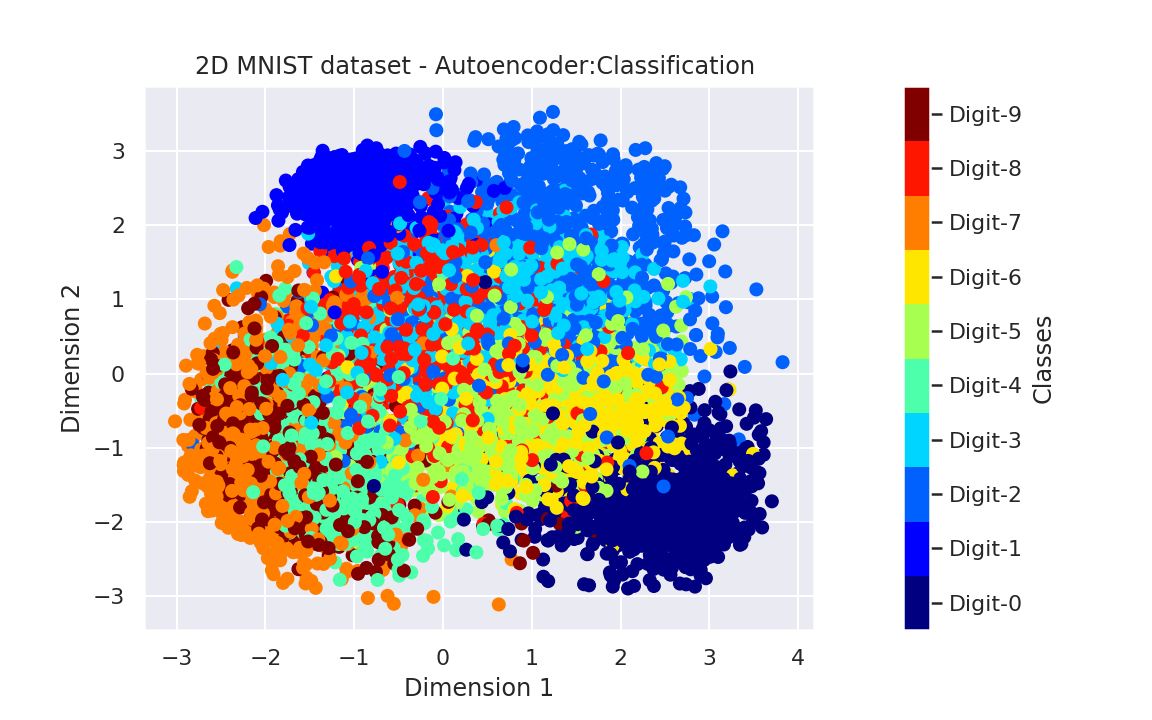

In [57]:
visualize_2d(X_test_reduced, y_test, "2D MNIST dataset - Autoencoder:Classification ", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                 "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                 "Digit-8","Digit-9"], "2d_plots/auto_c_mnist.png", 
                                                                         "Dimension 1", "Dimension 2")

In [ ]:
#reduced data 
mnist_3_c = get_reduced_dimension_data( ,reduced_dimension=3,)

In [58]:
#reduced data -
dataset = 'mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

# model = Model(num_hidden=128,input_size=X_train.shape[-1],classification=True)
# prefix = 'base_model'
# results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
#                       momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)


<IPython.core.display.Javascript object>


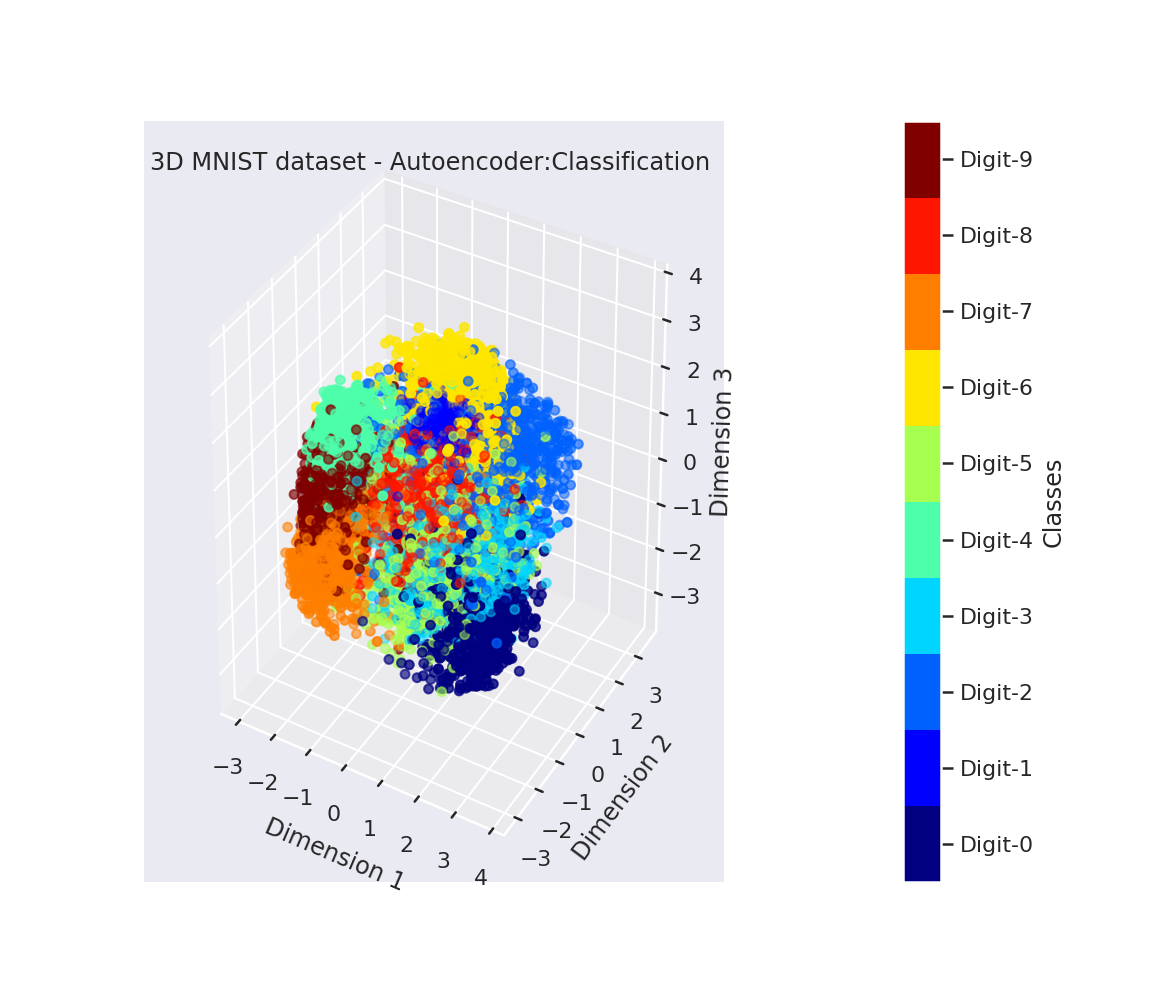

In [59]:
visualize_3d(X_test_reduced, y_test, "3D MNIST dataset - Autoencoder:Classification ", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                             "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                             "Digit-8","Digit-9"], "Dimension 1", 
                                                                         "Dimension 2", "Dimension 3")

### FASHION-MNIST

In [ ]:
# FASHION DATA
auto_f_data = train_data
f_label = train_labels

In [66]:
#reduced data -
dataset = 'fashion-mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=128,input_size=X_train.shape[-1])
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)
Epoch: [1/10] 	Batch: [0/859] 	loss: 620.4453
Epoch: [1/10] 	Batch: [400/859] 	loss: 70.8151
Epoch: [1/10] 	Batch: [800/859] 	loss: 58.9507
Epoch: [2/10] 	Batch: [0/859] 	loss: 58.0873
Epoch: [2/10] 	Batch: [400/859] 	loss: 54.0993
Epoch: [2/10] 	Batch: [800/859] 	loss: 49.5410
Epoch: [3/10] 	Batch: [0/859] 	loss: 37.1643
Epoch: [3/10] 	Batch: [400/859] 	loss: 43.2419
Epoch: [3/10] 	Batch: [800/859] 	loss: 38.4253
Epoch: [4/10] 	Batch: [0/859] 	loss: 47.9924
Epoch: [4/10] 	Batch: [400/859] 	loss: 40.9703
Epoch: [4/10] 	Batch: [800/859] 	loss: 38.2791
Epoch: [5/10] 	Batch: [0/859] 	loss: 39.9674
Epoch: [5/10] 	Batch: [400/859] 	loss: 38.4156
Epoch: [5/10] 	Batch: [800/859] 	loss: 31.4372
Epoch: [6/10] 	Batch: [0/859] 	loss: 34.2635
Epoch: [6/10] 	Batch: [400/859] 	loss: 27.7408
Epoch: [6/10] 	Batch: [800/859]

<IPython.core.display.Javascript object>


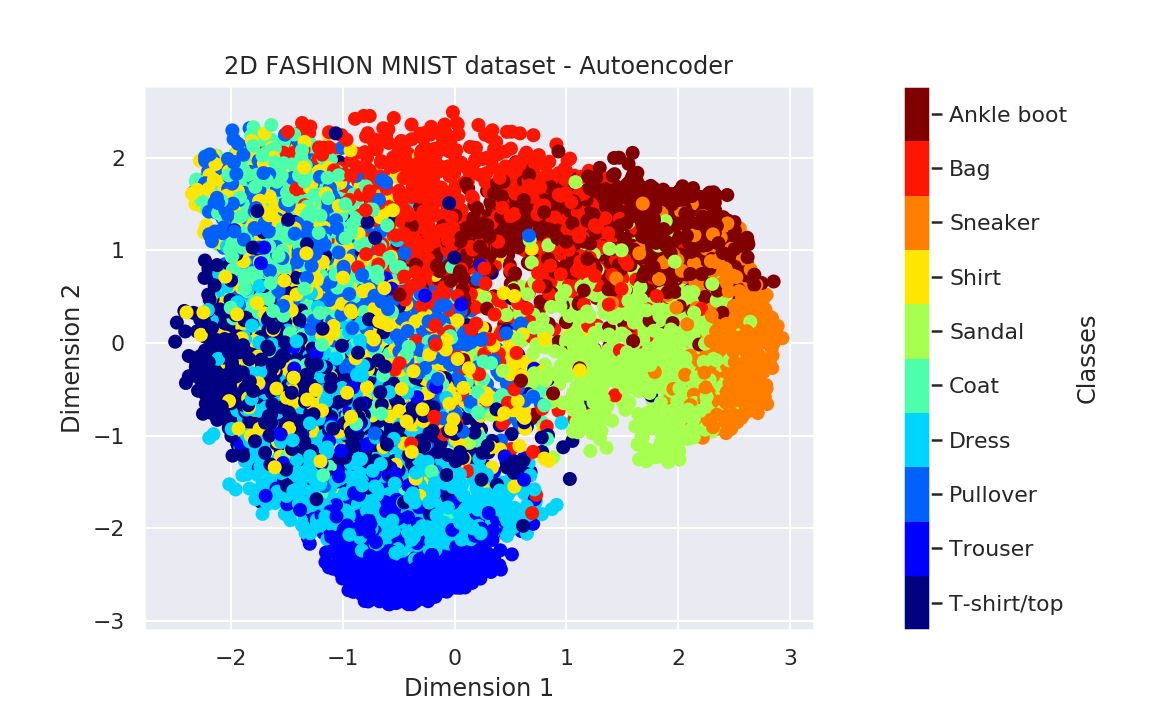

In [67]:
visualize_2d(X_test_reduced, y_test, "2D FASHION MNIST dataset - Autoencoder",["T-shirt/top","Trouser","Pullover","Dress","Coat",
                                                                           "Sandal","Shirt","Sneaker","Bag","Ankle boot"], 
                                                                            "2d_plots/auto_fashion.png", 
                                                                         "Dimension 1", "Dimension 2")

In [70]:
#reduced data -
dataset = 'fashion-mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=128,input_size=X_train.shape[-1],classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)
Epoch: [1/10] 	Batch: [0/859] 	loss: 2.3040
Epoch: [1/10] 	Batch: [400/859] 	loss: 1.4505
Epoch: [1/10] 	Batch: [800/859] 	loss: 1.2712

train_loss: 1.0901	 val_loss: 1.1033	 train_acc: 0.7003	 val_acc: 0.6892

Epoch: [2/10] 	Batch: [0/859] 	loss: 1.1184
Epoch: [2/10] 	Batch: [400/859] 	loss: 0.8874
Epoch: [2/10] 	Batch: [800/859] 	loss: 0.7368

train_loss: 0.8093	 val_loss: 0.8247	 train_acc: 0.7434	 val_acc: 0.7336

Epoch: [3/10] 	Batch: [0/859] 	loss: 0.8362
Epoch: [3/10] 	Batch: [400/859] 	loss: 0.8479
Epoch: [3/10] 	Batch: [800/859] 	loss: 0.6736

train_loss: 0.7013	 val_loss: 0.7168	 train_acc: 0.7589	 val_acc: 0.7460

Epoch: [4/10] 	Batch: [0/859] 	loss: 0.7112
Epoch: [4/10] 	Batch: [400/859] 	loss: 0.7514
Epoch: [4/10] 	Batch: [800/859] 	loss: 0.6308

train_loss: 0.6426	 val_loss: 0.6590	 train_acc: 

<IPython.core.display.Javascript object>


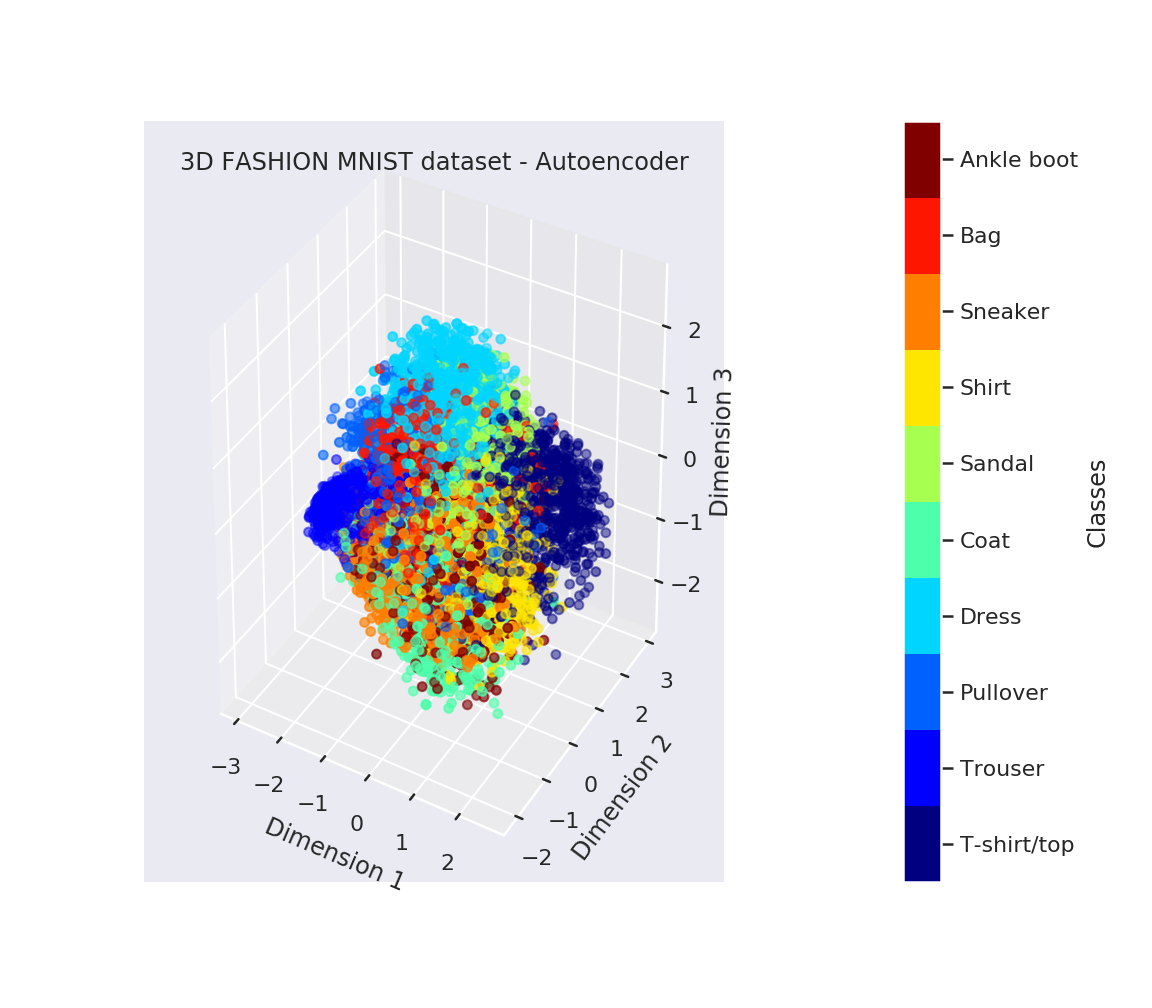

In [69]:
visualize_3d(X_test_reduced, y_test, "3D FASHION MNIST dataset - Autoencoder", ["T-shirt/top","Trouser","Pullover","Dress","Coat",
                                                                  "Sandal","Shirt","Sneaker","Bag","Ankle boot"], 
                                                                 "Dimension 1", "Dimension 2", "Dimension 3")

#### Classification mode

In [71]:
#reduced data -
#reduced data -
dataset = 'fashion-mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=128,input_size=X_train.shape[-1],classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)
Epoch: [1/10] 	Batch: [0/859] 	loss: 614.1812
Epoch: [1/10] 	Batch: [400/859] 	loss: 67.7549
Epoch: [1/10] 	Batch: [800/859] 	loss: 50.7942
Epoch: [2/10] 	Batch: [0/859] 	loss: 54.6725
Epoch: [2/10] 	Batch: [400/859] 	loss: 55.8547
Epoch: [2/10] 	Batch: [800/859] 	loss: 53.3238
Epoch: [3/10] 	Batch: [0/859] 	loss: 47.9776
Epoch: [3/10] 	Batch: [400/859] 	loss: 45.2418
Epoch: [3/10] 	Batch: [800/859] 	loss: 38.9330
Epoch: [4/10] 	Batch: [0/859] 	loss: 38.5862
Epoch: [4/10] 	Batch: [400/859] 	loss: 40.9593
Epoch: [4/10] 	Batch: [800/859] 	loss: 38.0517
Epoch: [5/10] 	Batch: [0/859] 	loss: 36.7517
Epoch: [5/10] 	Batch: [400/859] 	loss: 31.6929
Epoch: [5/10] 	Batch: [800/859] 	loss: 36.0734
Epoch: [6/10] 	Batch: [0/859] 	loss: 31.5500
Epoch: [6/10] 	Batch: [400/859] 	loss: 34.6489
Epoch: [6/10] 	Batch: [800/859]

<IPython.core.display.Javascript object>


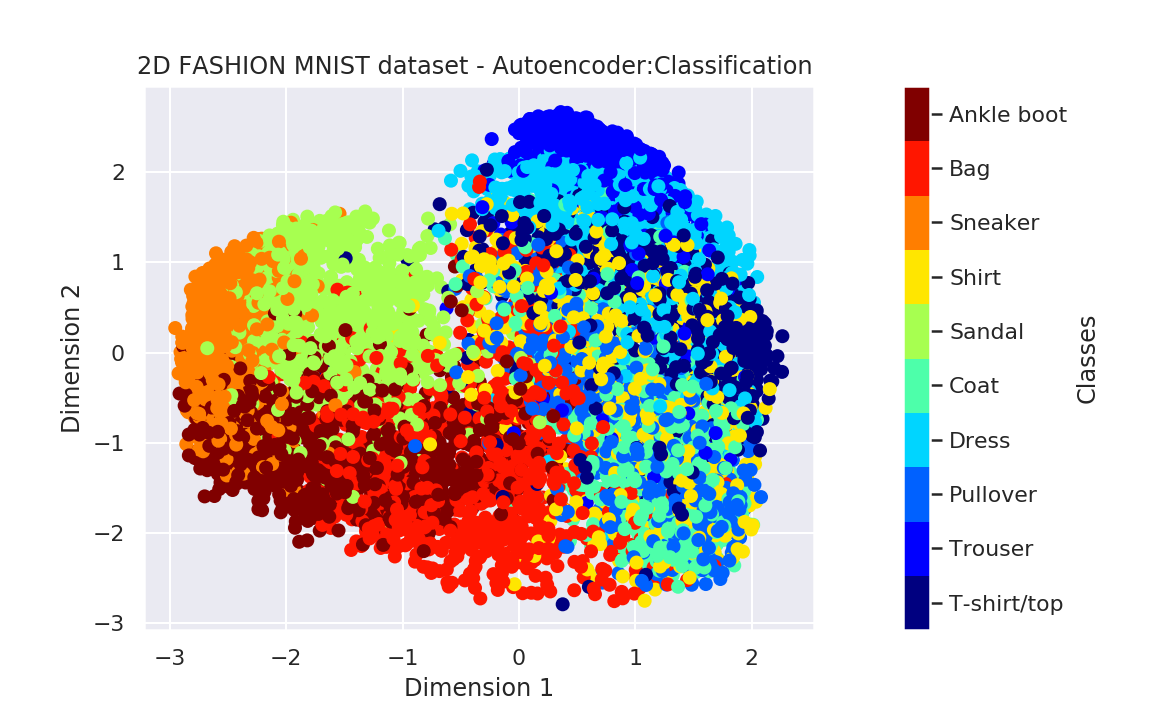

In [72]:
visualize_2d(X_test_reduced,y_test, "2D FASHION MNIST dataset - Autoencoder:Classification ",["T-shirt/top","Trouser","Pullover","Dress","Coat",
                                                                           "Sandal","Shirt","Sneaker","Bag","Ankle boot"], 
                                                                            "2d_plots/auto_c_fashion.png", 
                                                                         "Dimension 1", "Dimension 2")

In [75]:
#reduced data -
dataset = 'fashion-mnist'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

# model = Model(num_hidden=128,input_size=X_train.shape[-1],classification=False)
# prefix = 'base_model'
# results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-6,
#                       momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)


<IPython.core.display.Javascript object>


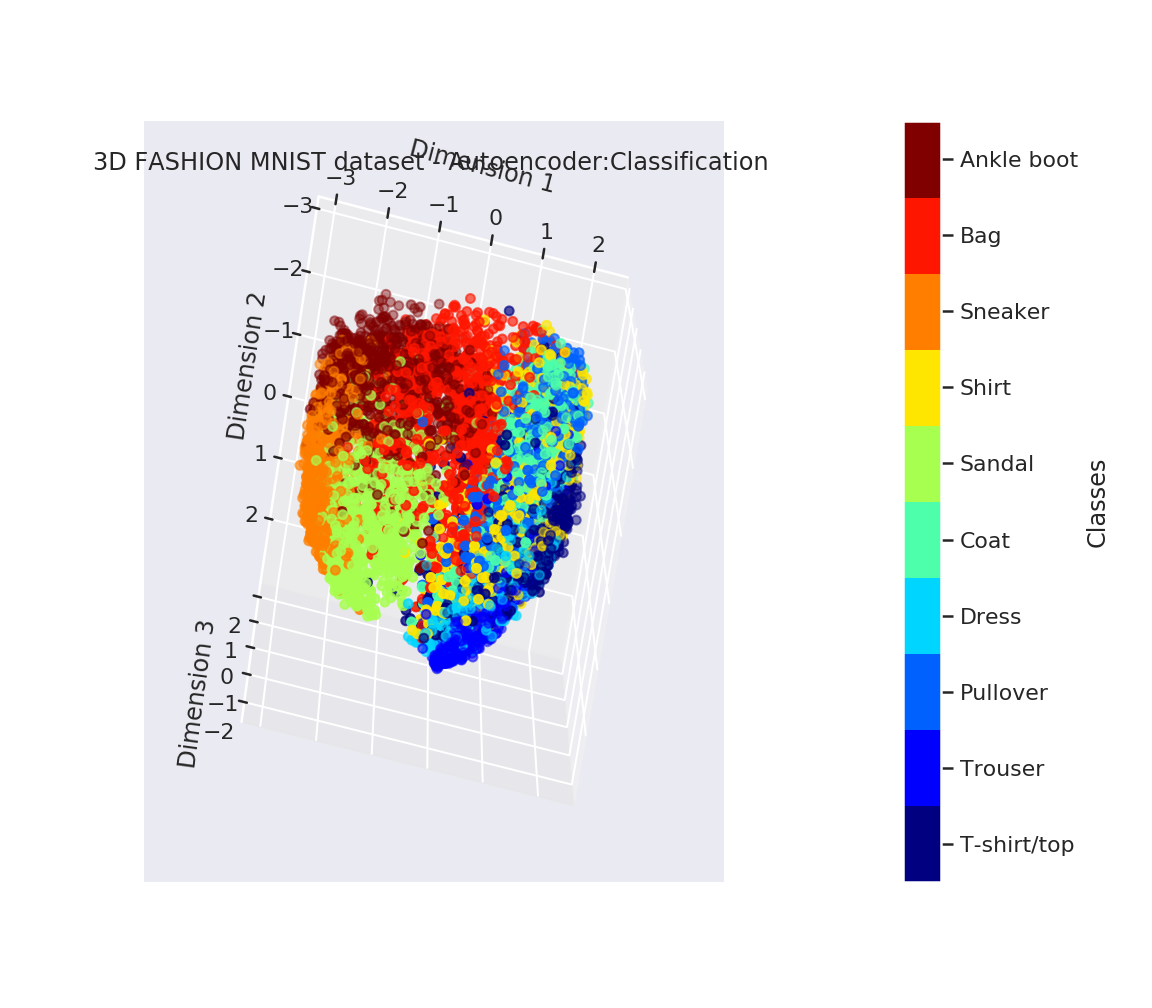

In [77]:
visualize_3d(X_test_reduced,y_test, "3D FASHION MNIST dataset - Autoencoder:Classification ", ["T-shirt/top","Trouser","Pullover","Dress","Coat",
                                                                  "Sandal","Shirt","Sneaker","Bag","Ankle boot"], 
                                                                 "Dimension 1", "Dimension 2", "Dimension 3")

### CIFAR-10

In [ ]:
# cifar DATA
auto_c_data = train_data
c_label = train_labels

In [78]:
#reduced data -
dataset = 'cifar-10'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=2*128,input_size=X_train.shape[-1])
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=20,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (45000, 3072) 	y_train: (45000,)
X_val: (5000, 3072) 	y_val: (5000,)
X_test: (10000, 3072) 	y_train: (10000,)
X_dev: (500, 3072) 	y_dev: (500,)
Epoch: [1/20] 	Batch: [0/703] 	loss: 944.0448
Epoch: [1/20] 	Batch: [400/703] 	loss: 176.1856
Epoch: [2/20] 	Batch: [0/703] 	loss: 168.8613
Epoch: [2/20] 	Batch: [400/703] 	loss: 144.1864
Epoch: [3/20] 	Batch: [0/703] 	loss: 126.4071
Epoch: [3/20] 	Batch: [400/703] 	loss: 130.1056
Epoch: [4/20] 	Batch: [0/703] 	loss: 119.7078
Epoch: [4/20] 	Batch: [400/703] 	loss: 117.1970
Epoch: [5/20] 	Batch: [0/703] 	loss: 99.0674
Epoch: [5/20] 	Batch: [400/703] 	loss: 145.2290
Epoch: [6/20] 	Batch: [0/703] 	loss: 93.2987
Epoch: [6/20] 	Batch: [400/703] 	loss: 113.8112
Epoch: [7/20] 	Batch: [0/703] 	loss: 101.8161
Epoch: [7/20] 	Batch: [400/703] 	loss: 105.8572
Epoch: [8/20] 	Batch: [0/703] 	loss: 87.5889
Epoch: [8/20] 	Batch: [400/703] 	loss: 100.8771
Epoch: [9/20] 	Batch: [0/703] 	loss: 81.2668
Epoch: [9/20] 	Batch:

<IPython.core.display.Javascript object>


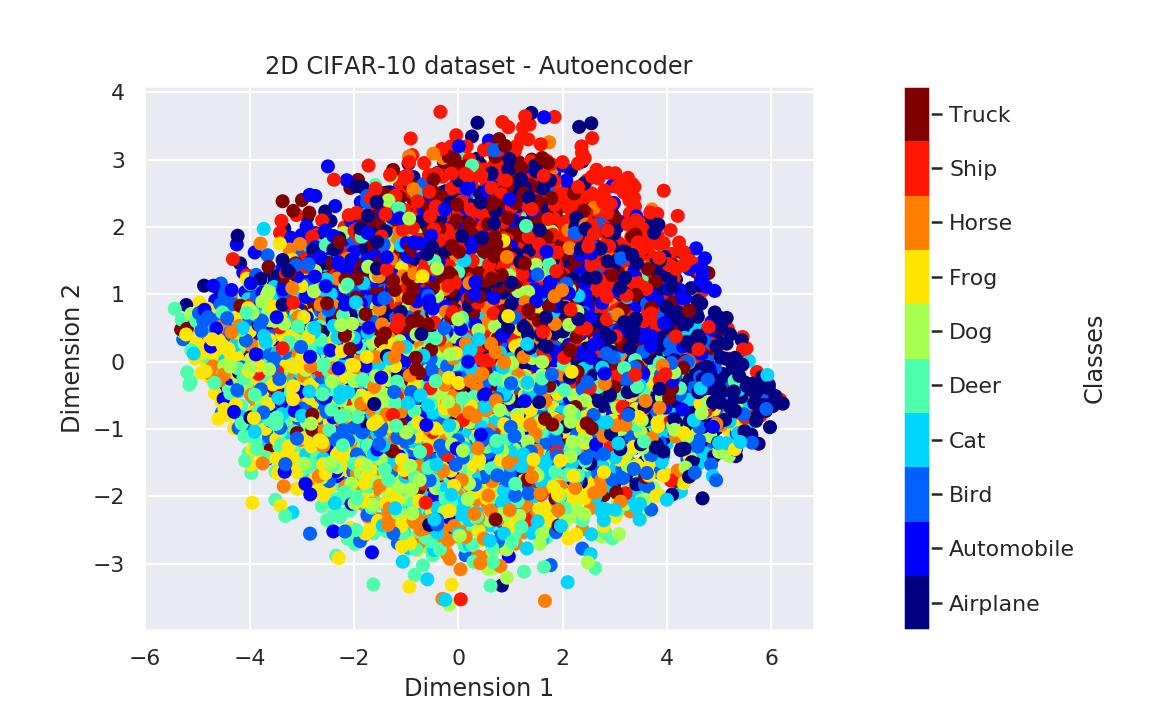

In [79]:
visualize_2d(X_test_reduced,y_test, "2D CIFAR-10 dataset - Autoencoder",["Airplane", "Automobile", "Bird", "Cat", "Deer","Dog",
                                                                    "Frog", "Horse","Ship","Truck"], 
                                                                            "2d_plots/auto_cifar.png", 
                                                                         "Dimension 1", "Dimension 2")

In [80]:
#reduced data -
#reduced data -
dataset = 'cifar-10'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

# model = Model(num_hidden=2*128,input_size=X_train.shape[-1])
# prefix = 'base_model'
# results = model.train(X_train,y_train,X_val,y_val,num_epochs=20,batch_size=64,lr=1e-2,reg=1e-6,
#                       momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (45000, 3072) 	y_train: (45000,)
X_val: (5000, 3072) 	y_val: (5000,)
X_test: (10000, 3072) 	y_train: (10000,)
X_dev: (500, 3072) 	y_dev: (500,)


<IPython.core.display.Javascript object>


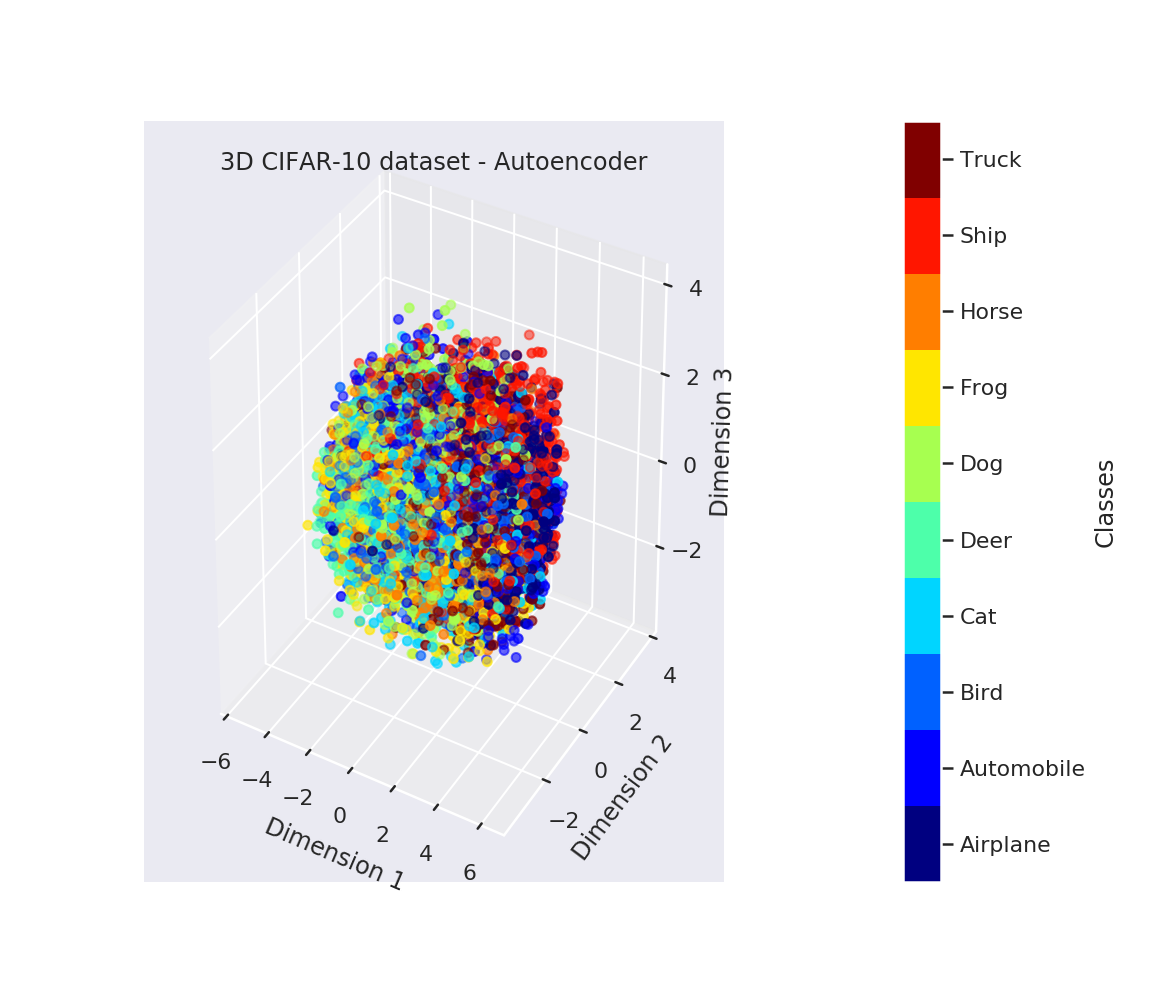

In [83]:
visualize_3d(X_test_reduced,y_test, "3D CIFAR-10 dataset - Autoencoder", ["Airplane", "Automobile", "Bird", "Cat", "Deer","Dog",
                                                                    "Frog", "Horse","Ship","Truck"],
                                                                 "Dimension 1", "Dimension 2", "Dimension 3")

#### Classification mode

In [84]:
#reduced data -
dataset = 'cifar-10'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

model = Model(num_hidden=2*128,input_size=X_train.shape[-1],classification=True)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=20,batch_size=64,lr=1e-2,reg=1e-6,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,2)

Loaded data ... Get data stats:
X_train: (45000, 3072) 	y_train: (45000,)
X_val: (5000, 3072) 	y_val: (5000,)
X_test: (10000, 3072) 	y_train: (10000,)
X_dev: (500, 3072) 	y_dev: (500,)
Epoch: [1/20] 	Batch: [0/703] 	loss: 2.3636
Epoch: [1/20] 	Batch: [400/703] 	loss: 2.0276

train_loss: 1.9940	 val_loss: 1.9988	 train_acc: 0.3040	 val_acc: 0.2988

Epoch: [2/20] 	Batch: [0/703] 	loss: 2.0051
Epoch: [2/20] 	Batch: [400/703] 	loss: 1.8938

train_loss: 1.8984	 val_loss: 1.9063	 train_acc: 0.3395	 val_acc: 0.3344

Epoch: [3/20] 	Batch: [0/703] 	loss: 1.9010
Epoch: [3/20] 	Batch: [400/703] 	loss: 1.9559

train_loss: 1.8501	 val_loss: 1.8596	 train_acc: 0.3606	 val_acc: 0.3616

Epoch: [4/20] 	Batch: [0/703] 	loss: 1.8029
Epoch: [4/20] 	Batch: [400/703] 	loss: 1.8453

train_loss: 1.8183	 val_loss: 1.8282	 train_acc: 0.3684	 val_acc: 0.3682

Epoch: [5/20] 	Batch: [0/703] 	loss: 1.7488
Epoch: [5/20] 	Batch: [400/703] 	loss: 1.7766

train_loss: 1.7936	 val_loss: 1.8060	 train_acc: 0.3776	 val_acc

<IPython.core.display.Javascript object>


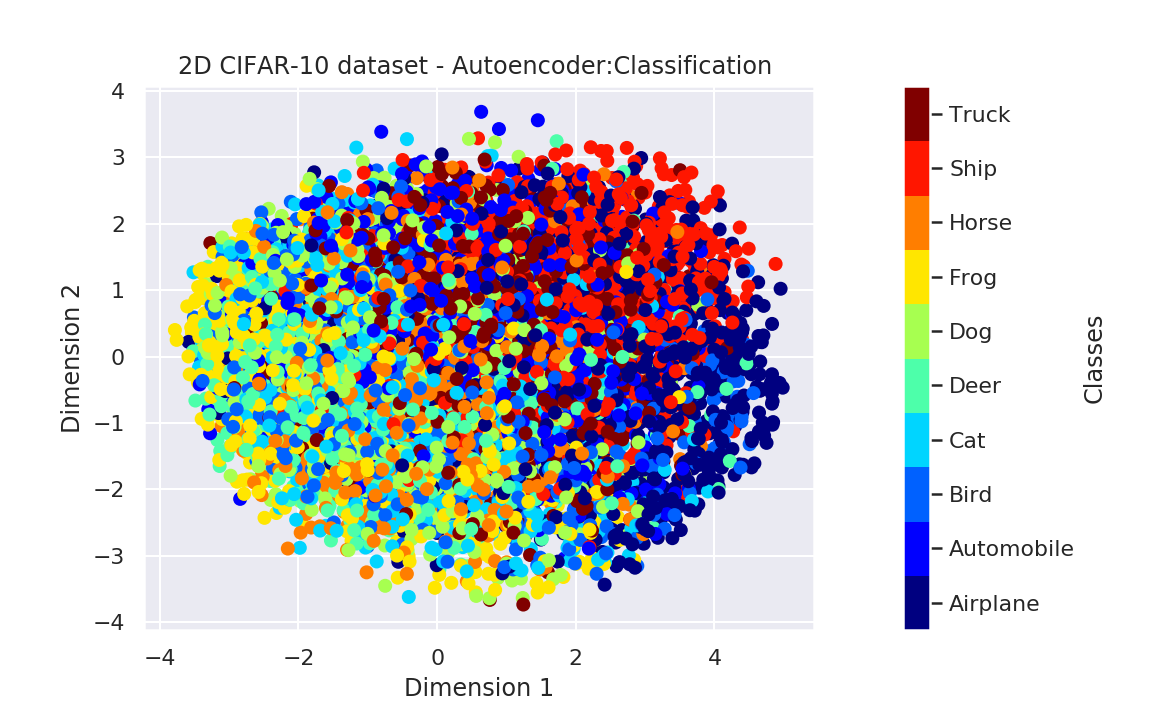

In [85]:
visualize_2d(X_test_reduced, y_test, "2D CIFAR-10 dataset - Autoencoder:Classification ",["Airplane", "Automobile", "Bird", 
                                                                                      "Cat", "Deer","Dog","Frog", "Horse",
                                                                                      "Ship","Truck"], 
                                                                                 "2d_plots/auto_c_cifar.png","Dimension 1",
                                                                                                     "Dimension 2")

In [86]:
#reduced data -
dataset = 'cifar-10'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(dataset)
X_train,X_val,X_test = normalize(X_train,X_val,X_test)

# model = Model(num_hidden=2*128,input_size=X_train.shape[-1],classification=True)
# prefix = 'base_model'
# results = model.train(X_train,y_train,X_val,y_val,num_epochs=20,batch_size=64,lr=1e-2,reg=1e-6,
#                       momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=True)

X_test_reduced = model.get_hidden_features(X_test)
_,X_test_reduced = pca(X_test_reduced,X_test_reduced,3)

Loaded data ... Get data stats:
X_train: (45000, 3072) 	y_train: (45000,)
X_val: (5000, 3072) 	y_val: (5000,)
X_test: (10000, 3072) 	y_train: (10000,)
X_dev: (500, 3072) 	y_dev: (500,)


<IPython.core.display.Javascript object>


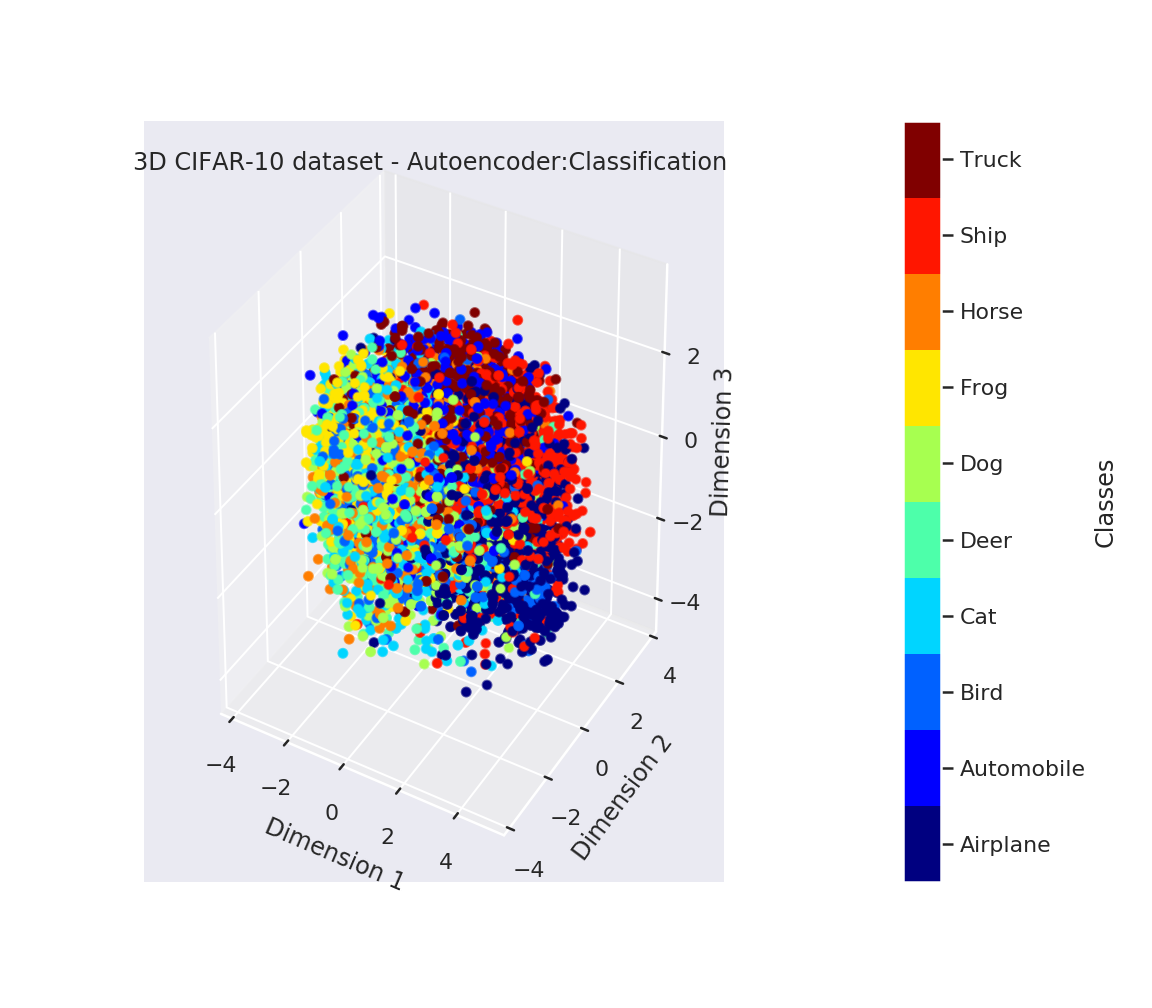

In [89]:
visualize_3d(X_test_reduced, y_test, "3D CIFAR-10 dataset - Autoencoder:Classification ", ["Airplane", "Automobile", "Bird", 
                                                                                       "Cat", "Deer","Dog","Frog", "Horse",
                                                                                       "Ship","Truck"], "Dimension 1", 
                                                                                         "Dimension 2", "Dimension 3")